# Experiment 1

In [1]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379450 sha256=51948e56c8659750ff169c069dd7dfa22f0d470f82d44982be0b7cacd1c8c72b
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import itertools
import random
import matplotlib.pyplot as plt
import warnings
from torch.nn.init import uniform_
import math
from google.colab import drive
import json
import os

warnings.filterwarnings("ignore")

drive.mount('/content/drive')
%cd "/content/drive/My Drive/ARL/exp1"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/My Drive/ARL/exp1


## Standard DQN

In [3]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 10000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
LEARNING_RATE = 0.0001
MAX_EPISODES = 1000

# Hyperparameters to tune
LOSS_FUNCTIONS = {"MSE": nn.MSELoss(), "HUBER": nn.SmoothL1Loss()}
TARGET_UPDATE_FREQUENCIES = [1, 10, 50, 100]

In [4]:
# Create environment
env = gym.make("LunarLander-v3")
obs, info = env.reset()
episode_reward = 0.0

In [5]:
Transition = namedtuple(
    "Transition", ("states", "actions", "rewards", "dones", "next_states")
)

class Replay_memory:

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32)).to(device)
        actions = (
            torch.from_numpy(np.array(batch.actions, dtype=np.int64))
            .unsqueeze(1)
            .to(device)
        )
        rewards = (
            torch.from_numpy(np.array(batch.rewards, dtype=np.float32))
            .unsqueeze(1)
            .to(device)
        )
        dones = (
            torch.from_numpy(np.array(batch.dones, dtype=np.bool8))
            .unsqueeze(1)
            .to(device)
        )
        next_states = torch.from_numpy(
            np.array(batch.next_states, dtype=np.float32)
        ).to(device)
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, info = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [6]:
replay_memory = Replay_memory(
    env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE
).initialize()

In [7]:
states, actions, rewards, dones, next_states = replay_memory.sample_batch()

In [8]:
states  # Transitions ('states', 'actions', 'rewards', 'dones', 'next_states') grouped to separate states, actions, rewards, dones, next_states

tensor([[-0.0285,  1.3342, -0.0877, -0.3311, -0.0311,  0.0677,  0.0000,  0.0000],
        [-0.4282,  1.2777, -0.9040, -0.6436,  0.5746,  0.3966,  0.0000,  0.0000],
        [-0.1837,  0.1674, -0.4982, -1.1739,  0.5466,  0.1425,  0.0000,  0.0000],
        [-0.5061,  0.4322, -0.3459, -1.1902, -0.5119,  0.0344,  0.0000,  0.0000],
        [-0.0116,  1.4255, -0.0768, -0.0444,  0.0556,  0.0427,  0.0000,  0.0000],
        [ 0.0064,  1.1049,  0.0315, -0.8382, -0.0388, -0.0916,  0.0000,  0.0000],
        [-0.0052,  1.4588, -0.0090, -0.1852,  0.0636,  0.0426,  0.0000,  0.0000],
        [-0.1931,  1.0827, -0.4171, -0.5535,  0.2233,  0.0953,  0.0000,  0.0000],
        [ 0.1003,  1.5787,  0.2621, -0.0749, -0.0795, -0.0329,  0.0000,  0.0000],
        [-0.0793,  1.1552, -0.4478, -0.7462,  0.0723, -0.0134,  0.0000,  0.0000],
        [ 0.3925,  0.1375,  0.5551, -1.4918, -0.7628, -0.2045,  0.0000,  0.0000],
        [ 0.0483,  1.4005,  0.3583, -0.1417, -0.0391, -0.0309,  0.0000,  0.0000],
        [ 0.3138

In [9]:
# Modified DQN architecture for LunarLander
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        # Larger network for more complex environment
        self.fc1 = nn.Linear(ninputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, noutputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
def train_with_parameters(loss_fn, target_update_freq):
    # Initialize networks and optimizer
    dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    dqn_target = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    dqn_target.load_state_dict(dqn_policy.state_dict())
    dqn_target.eval()
    dqn_policy.train()

    optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=LEARNING_RATE)

    # Define epsilon_greedy_policy as an inner function to access dqn_policy
    def epsilon_greedy_policy(epsilon, obs):
        rnd_sample = random.random()
        if rnd_sample <= epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                action = int(torch.argmax(dqn_policy(obs_tensor)))
        return action

    obs, info = env.reset()
    episode_rewards = []
    eps_threshold = EPS_START
    episode = 1
    episode_reward = 0.0
    convergence_episode = float("inf")  # Track when solving criterion is met

    for step in itertools.count():
        action = epsilon_greedy_policy(eps_threshold, obs)
        new_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_memory.append(Transition(obs, action, reward, done, new_obs))
        episode_reward += reward
        obs = new_obs

        if done:
            episode += 1
            eps_threshold = max(eps_threshold * EPS_DECAY, EPS_END)
            replay_memory.rewards.append(episode_reward)
            obs, info = env.reset()
            episode_rewards.append(episode_reward)

            # Print individual episode reward
            print(f"Episode {episode}: Reward = {episode_reward:.2f}")

            # Calculate average reward
            avg_reward = np.mean(episode_rewards[-50:])

            if episode % 50 == 0:
                print(
                    f"Episode: {episode} Avg Reward: {avg_reward:.2f} Epsilon: {eps_threshold:.3f}"
                )

            if avg_reward >= 195 and convergence_episode == float("inf"):
                convergence_episode = episode
                print(
                    f"Solving criterion met at episode {episode}! Average reward: {avg_reward:.2f}"
                )
                break

            if episode >= MAX_EPISODES:
                break

            episode_reward = 0

        # Sample batch from replay memory
        b_states, b_actions, b_rewards, b_dones, b_next_states = (
            replay_memory.sample_batch()
        )

        # Compute Q-values
        qvalues = dqn_policy(b_states).gather(1, b_actions)

        # Compute target Q-values
        with torch.no_grad():
            target_qvalues = dqn_target(b_next_states)
            max_target_qvalues = torch.max(target_qvalues, dim=1).values.unsqueeze(1)
            expected_qvalues = (
                b_rewards + GAMMA * (1 - b_dones.float()) * max_target_qvalues
            )

        # Compute loss and backpropagate
        optimizer.zero_grad()
        loss = loss_fn(qvalues, expected_qvalues)
        loss.backward()

        optimizer.step()

        if episode % target_update_freq == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

    return episode_rewards, convergence_episode

In [11]:
results_file = 'hyper_param_results.json'

# Check if results file exists
if os.path.exists(results_file):
    # Load existing results
    with open(results_file, 'r') as f:
        data = json.load(f)
        results = data['results']
        convergence_episodes = data['convergence_episodes']
    print(f"Loaded existing results from {results_file}")
else:
    # Run the training loops
    results = {}
    convergence_episodes = {}
    for loss_name, loss_fn in LOSS_FUNCTIONS.items():
        for freq in TARGET_UPDATE_FREQUENCIES:
            key = f"{loss_name}_freq{freq}"
            print(f"\nTraining with {key}")
            rewards, conv_episode = train_with_parameters(loss_fn, freq)
            results[key] = rewards
            convergence_episodes[key] = (
                conv_episode if conv_episode != float("inf") else 1000
            )

    # Save results to JSON
    with open(results_file, 'w') as f:
        json.dump({
            'results': results,
            'convergence_episodes': convergence_episodes
        }, f)
    print(f"Saved results to {results_file}")

Loaded existing results from hyper_param_results.json


In [12]:
# Analyze and plot results
# Sort combinations by convergence episode
sorted_combinations = sorted(convergence_episodes.items(), key=lambda x: x[1])

# Print sorted combinations
print("\nCombinations sorted by convergence speed:")
for combination, conv_episode in sorted_combinations:
    print(
        f"{combination}: {'Did not converge' if conv_episode == 1000 else f'Converged at episode {conv_episode}'}"
    )


Combinations sorted by convergence speed:
HUBER_freq1: Converged at episode 389
MSE_freq1: Converged at episode 478
HUBER_freq10: Converged at episode 492
MSE_freq10: Converged at episode 686
HUBER_freq50: Did not converge
HUBER_freq100: Did not converge
MSE_freq50: Did not converge
MSE_freq100: Did not converge


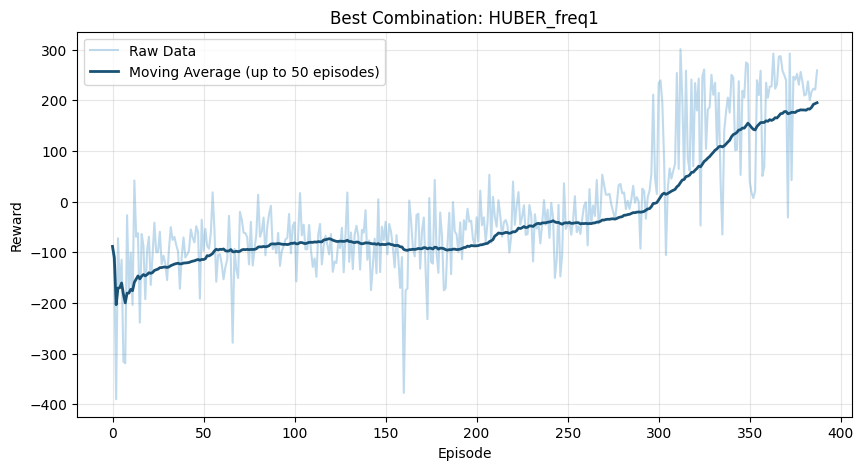

In [13]:
# Plot the best combination with moving average
best_key = sorted_combinations[0][0]
max_window = 50  # Maximum size of the moving average window

# Calculate variable window moving average
rewards = np.array(results[best_key])
moving_avg = []
for i in range(len(rewards)):
    # Use window size that grows up to max_window
    window = min(i + 1, max_window)
    start_idx = max(0, i + 1 - window)
    moving_avg.append(np.mean(rewards[start_idx:i + 1]))

# Convert to numpy array for plotting
moving_avg = np.array(moving_avg)

# Create x-axis values
x_raw = np.arange(len(rewards))

# Create the plot
plt.figure(figsize=(10, 5))

# Plot both raw data (light) and moving average (dark)
plt.plot(
    x_raw,
    rewards,
    alpha=0.3,
    color='#2E86C1',
    label='Raw Data'
)
plt.plot(
    x_raw,
    moving_avg,
    color='#1A5276',
    linewidth=2,
    label=f'Moving Average (up to {max_window} episodes)'
)

plt.title(f"Best Combination: {best_key}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

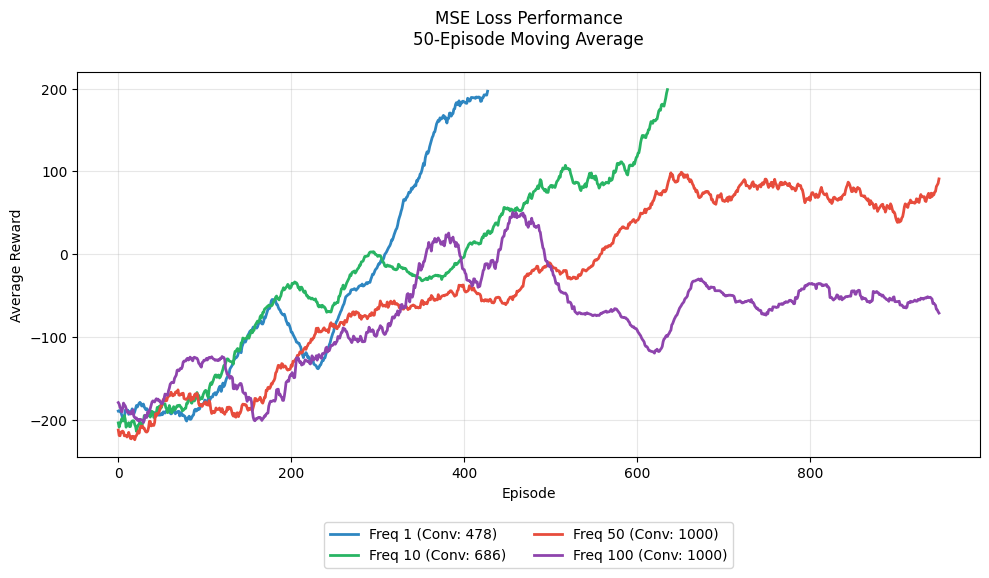

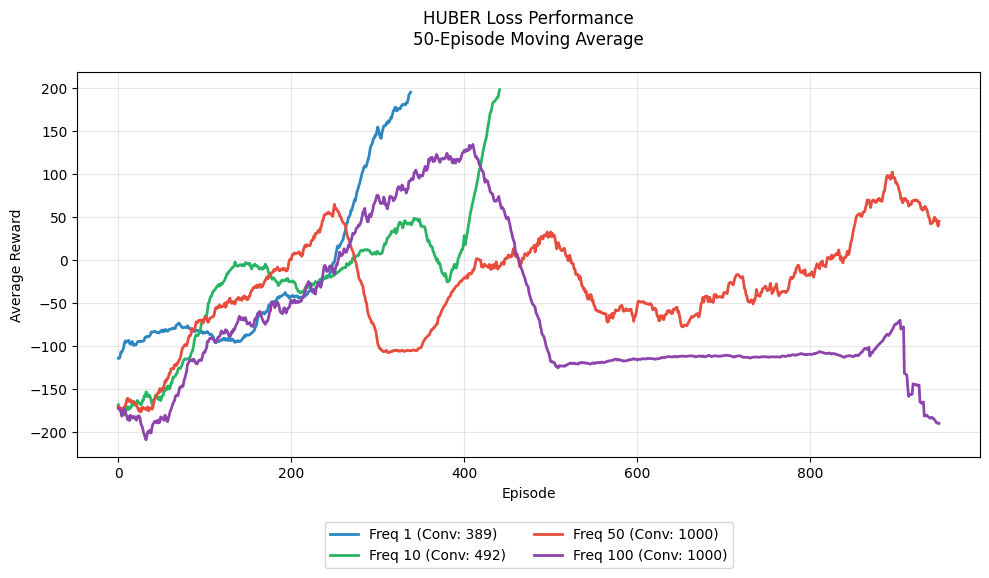

In [26]:
# Create individual plots for each loss function with moving averages
window_size = 50  # Size of the moving average window
colors = ["#2E86C1", "#28B463", "#E74C3C", "#8E44AD"]  # More distinct colors

# Plot each loss function separately
for i, (loss_name, loss_fn) in enumerate(LOSS_FUNCTIONS.items()):
    plt.figure(figsize=(10, 6))

    for j, freq in enumerate(TARGET_UPDATE_FREQUENCIES):
        key = f"{loss_name}_freq{freq}"

        # Calculate moving average
        moving_avg = np.convolve(
            results[key],
            np.ones(window_size) / window_size,
            mode='valid'
        )

        # Plot moving average
        plt.plot(
            moving_avg,
            color=colors[j],
            linewidth=2,
            label=f"Freq {freq} (Conv: {convergence_episodes[key]})"
        )

    plt.title(f"{loss_name} Loss Performance\n{window_size}-Episode Moving Average", pad=20)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Noisy DQN:

In [15]:
TARGET_UPDATE_FREQ = 10
LOSS_FN = nn.SmoothL1Loss()

In [16]:
class NoisyLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(NoisyLinear, self).__init__()

        self.w_mu = nn.Parameter(torch.empty((out_size, in_size)))
        self.w_sigma = nn.Parameter(torch.empty((out_size, in_size)))
        self.b_mu = nn.Parameter(torch.empty((out_size)))
        self.b_sigma = nn.Parameter(torch.empty((out_size)))

        # Initialize parameters
        uniform_(self.w_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        uniform_(self.b_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        nn.init.constant_(self.w_sigma, 0.017)  # Fixed initialization for stability
        nn.init.constant_(self.b_sigma, 0.017)

    def forward(self, x, sigma=1):
        if self.training:
            w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(x.device)
            b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(x.device)
            return F.linear(
                x,
                self.w_mu + self.w_sigma * w_noise,
                self.b_mu + self.b_sigma * b_noise,
            )
        else:
            return F.linear(x, self.w_mu, self.b_mu)

class DQN_Noisy(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN_Noisy, self).__init__()
        # Using larger layers for LunarLander's complexity
        self.a1 = NoisyLinear(ninputs, 128)
        self.a2 = NoisyLinear(128, 128)
        self.a3 = NoisyLinear(128, noutputs)

    def forward(self, x):
        x = F.relu(self.a1(x))
        x = F.relu(self.a2(x))
        return self.a3(x)

Modified training function to incorproate noisy changes:

- different optimiser
- no need for epsilon greedy

In [17]:
def train_with_parameters_noisy(agent_class):
    # Initialize networks and optimizer
    dqn_policy = agent_class(env.observation_space.shape[0], env.action_space.n).to(
        device
    )
    dqn_target = agent_class(env.observation_space.shape[0], env.action_space.n).to(
        device
    )
    dqn_target.load_state_dict(dqn_policy.state_dict())
    dqn_target.eval()
    dqn_policy.train()

    # Choose optimizer based on agent type
    optimizer = (torch.optim.AdamW if agent_class == DQN_Noisy else torch.optim.Adam)(
        dqn_policy.parameters(), lr=LEARNING_RATE
    )

    # Define action selection strategies
    def epsilon_greedy_policy(epsilon, obs):
        rnd_sample = random.random()
        if rnd_sample <= epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                action = int(torch.argmax(dqn_policy(obs_tensor)))
        return action

    def select_action(obs):
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            action = int(torch.argmax(dqn_policy(obs_tensor)))
        return action

    # Choose action selection strategy based on agent type
    action_selector = (
        select_action
        if agent_class == DQN_Noisy
        else lambda obs: epsilon_greedy_policy(eps_threshold, obs)
    )

    obs, info = env.reset()
    episode_rewards = []
    eps_threshold = EPS_START
    episode = 1
    episode_reward = 0.0
    convergence_episode = float("inf")

    for step in itertools.count():
        action = action_selector(obs)
        new_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_memory.append(Transition(obs, action, reward, done, new_obs))
        episode_reward += reward
        obs = new_obs

        if done:
            episode += 1
            # Only update epsilon for regular DQN
            if agent_class == DQN:
                eps_threshold = max(eps_threshold * EPS_DECAY, EPS_END)

            replay_memory.rewards.append(episode_reward)
            obs, info = env.reset()
            episode_rewards.append(episode_reward)

            print(f"Episode {episode}: Reward = {episode_reward:.2f}")
            avg_reward = np.mean(episode_rewards[-50:])

            if episode % 50 == 0:
                epsilon_info = (
                    f"Epsilon: {eps_threshold:.3f}"
                    if agent_class == DQN
                    else "Using Noisy Nets"
                )
                print(f"Episode: {episode} Avg Reward: {avg_reward:.2f} {epsilon_info}")

            if avg_reward >= 195 and convergence_episode == float("inf"):
                convergence_episode = episode
                print(
                    f"Solving criterion met at episode {episode}! Average reward: {avg_reward:.2f}"
                )
                break


            if episode >= MAX_EPISODES:
                break

            episode_reward = 0

        b_states, b_actions, b_rewards, b_dones, b_next_states = (
            replay_memory.sample_batch()
        )

        qvalues = dqn_policy(b_states).gather(1, b_actions)

        with torch.no_grad():
            target_qvalues = dqn_target(b_next_states)
            max_target_qvalues = torch.max(target_qvalues, dim=1).values.unsqueeze(1)
            expected_qvalues = (
                b_rewards + GAMMA * (1 - b_dones.float()) * max_target_qvalues
            )

        optimizer.zero_grad()
        loss = LOSS_FN(qvalues, expected_qvalues)
        loss.backward()
        optimizer.step()

        if episode % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

    return episode_rewards, convergence_episode


In [18]:
comparison_file = 'comparison_results.json'

dqns = {"Standard": DQN, "Noisy": DQN_Noisy}

# Check if comparison results file exists
if os.path.exists(comparison_file):
    # Load existing results
    with open(comparison_file, 'r') as f:
        data = json.load(f)
        comparison_results = data['comparison_results']
        comparison_convergence_episodes = data['comparison_convergence_episodes']
    print(f"Loaded existing comparison results from {comparison_file}")
else:
    # Run the training loops
    comparison_results = {}
    comparison_convergence_episodes = {}
    for key, dqn in dqns.items():
        print(f"\nTraining {key} DQN")
        rewards, conv_episode = train_with_parameters_noisy(dqn)
        comparison_results[key] = rewards
        comparison_convergence_episodes[key] = (
            conv_episode if conv_episode != float("inf") else 1000
        )

    # Convert NumPy arrays to lists before saving
    results_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in comparison_results.items()}
    convergence_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in comparison_convergence_episodes.items()}

    # Save results to JSON
    with open(comparison_file, 'w') as f:
        json.dump({
            'comparison_results': results_to_save,
            'comparison_convergence_episodes': convergence_to_save
        }, f)
    print(f"Saved comparison results to {comparison_file}")

Loaded existing comparison results from comparison_results.json


In [19]:
# Print comparison results
print("\nDQN Variants Comparison (Sorted by convergence speed):")
sorted_variants = sorted(comparison_convergence_episodes.items(), key=lambda x: x[1])
for variant, conv_episode in sorted_variants:
    print(
        f"{variant} DQN: {'Did not converge' if conv_episode == 1000 else f'Converged at episode {conv_episode}'}"
    )


DQN Variants Comparison (Sorted by convergence speed):
Standard DQN: Converged at episode 511
Noisy DQN: Converged at episode 583


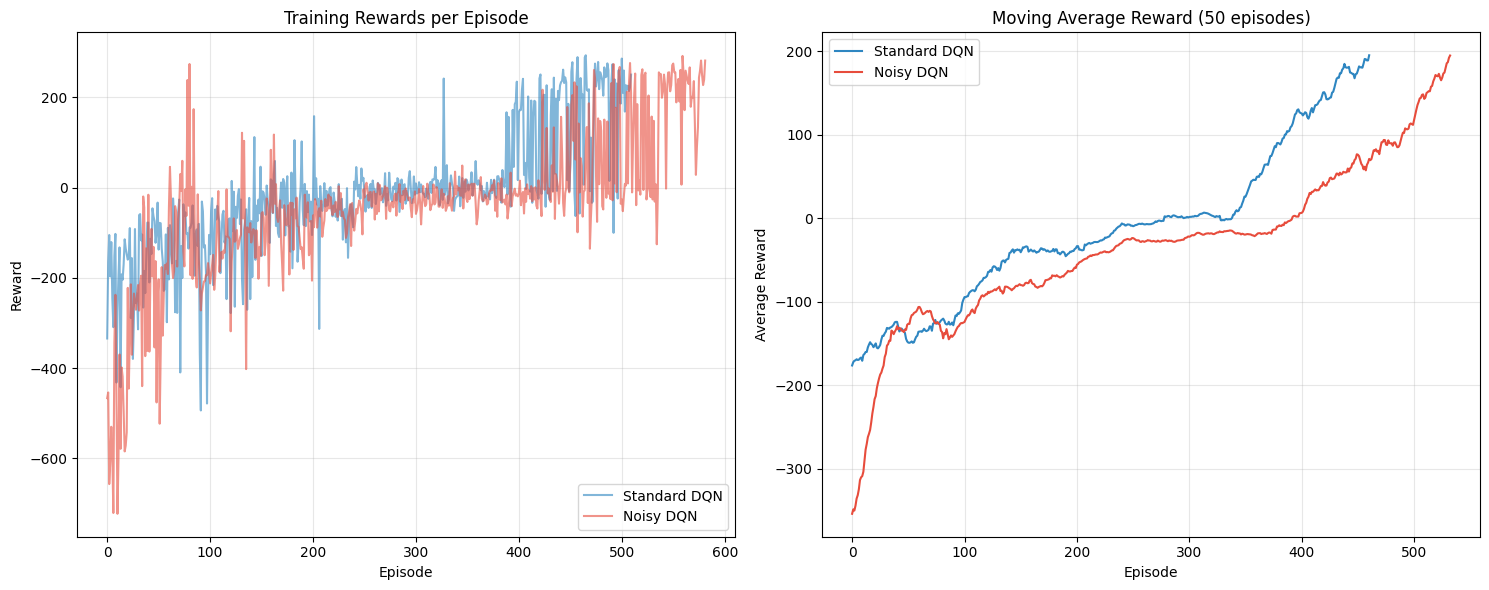

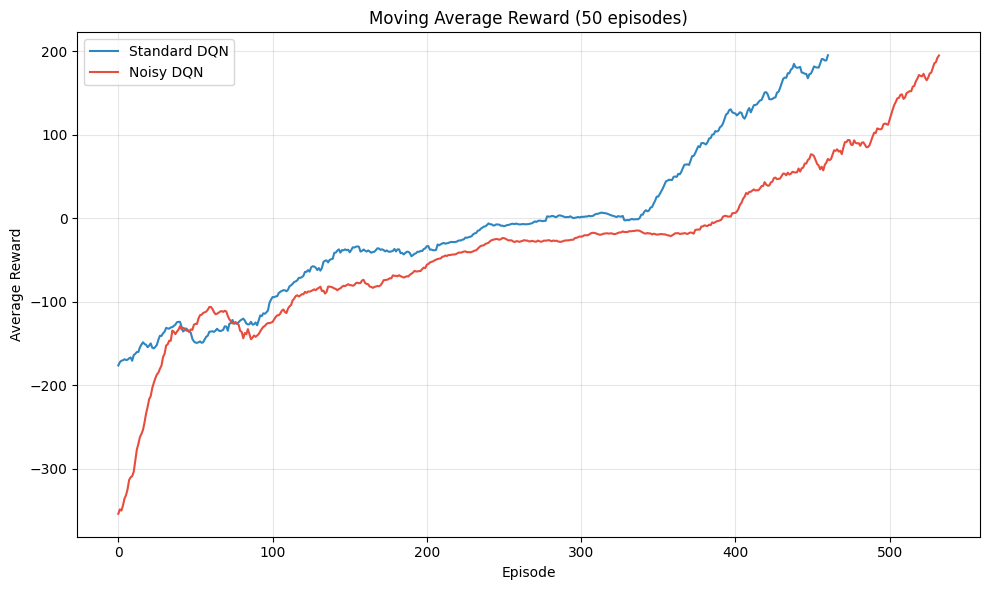

In [27]:
# First plot: Original comparison with 2 subplots
colors = {"Standard": "#2E86C1", "Noisy": "#E74C3C"}  # Blue for Standard, Red for Noisy
plt.figure(figsize=(15, 6))

# Subplot 1: Raw rewards
plt.subplot(1, 2, 1)
for variant, rewards in comparison_results.items():
    plt.plot(rewards, label=f"{variant} DQN", color=colors[variant], alpha=0.6)
plt.title("Training Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Moving average rewards
plt.subplot(1, 2, 2)
window_size = 50
for variant, rewards in comparison_results.items():
    moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
    plt.plot(moving_avg, label=f"{variant} DQN", color=colors[variant])
plt.title(f"Moving Average Reward ({window_size} episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Second plot: Just the moving averages
plt.figure(figsize=(10, 6))
window_size = 50
for variant, rewards in comparison_results.items():
    moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
    plt.plot(moving_avg, label=f"{variant} DQN", color=colors[variant])
plt.title(f"Moving Average Reward ({window_size} episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Effect of Noise

In [21]:
def inject_gausiian_noise(state, noise_value):
    """
    Injects Gaussian noise into the given state tensor.

    Parameters:
    - state (torch.Tensor): The state tensor to inject noise into.
    - noise_value (float): The standard deviation of the Gaussian noise.

    Returns:
    - torch.Tensor: The state tensor with injected Gaussian noise.
    """
    if noise_value == "LOW":
        noise_level = 0.01
    elif noise_value == "MEDIUM":
        noise_level = 0.05
    elif noise_value == "HIGH":
        noise_level = 0.1
    else:
        raise ValueError(f"Invalid noise level: {noise_value}")

    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)

    noise = torch.randn(state.size()) * noise_level
    noisy_state = state + noise
    return noisy_state

In [22]:
def train_with_parameters_noisy(
    agent_class, noise_level=None
):
    """
    Modified training function that supports state noise injection
    """
    dqn_policy = agent_class(env.observation_space.shape[0], env.action_space.n).to(
        device
    )
    dqn_target = agent_class(env.observation_space.shape[0], env.action_space.n).to(
        device
    )
    dqn_target.load_state_dict(dqn_policy.state_dict())
    dqn_target.eval()
    dqn_policy.train()

    optimizer = (torch.optim.AdamW if agent_class == DQN_Noisy else torch.optim.Adam)(
        dqn_policy.parameters(), lr=LEARNING_RATE
    )

    def select_action(obs, eps_threshold=None):
        # Add noise to observation if specified
        if noise_level:
            obs = inject_gausiian_noise(obs, noise_level)

        if agent_class == DQN_Noisy:
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                action = int(torch.argmax(dqn_policy(obs_tensor)))
            return action
        else:
            # Epsilon-greedy for standard DQN
            if random.random() <= eps_threshold:
                return env.action_space.sample()
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                return int(torch.argmax(dqn_policy(obs_tensor)))

    obs, info = env.reset()
    episode_rewards = []
    eps_threshold = EPS_START
    episode = 1
    episode_reward = 0.0
    convergence_episode = float("inf")

    for step in itertools.count():
        action = select_action(obs, eps_threshold)
        new_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_memory.append(Transition(obs, action, reward, done, new_obs))
        episode_reward += reward
        obs = new_obs

        if done:
            episode += 1
            # Only update epsilon for regular DQN
            if agent_class == DQN:
                eps_threshold = max(eps_threshold * EPS_DECAY, EPS_END)

            replay_memory.rewards.append(episode_reward)
            obs, info = env.reset()
            episode_rewards.append(episode_reward)

            print(f"Episode {episode}: Reward = {episode_reward:.2f}")
            avg_reward = np.mean(episode_rewards[-50:])

            if episode % 50 == 0:
                epsilon_info = (
                    f"Epsilon: {eps_threshold:.3f}"
                    if agent_class == DQN
                    else "Using Noisy Nets"
                )
                print(f"Episode: {episode} Avg Reward: {avg_reward:.2f} {epsilon_info}")

            if avg_reward >= 195 and convergence_episode == float("inf"):
                convergence_episode = episode
                print(
                    f"Solving criterion met at episode {episode}! Average reward: {avg_reward:.2f}"
                )
                break

            if episode >= MAX_EPISODES:
                break

            episode_reward = 0

        b_states, b_actions, b_rewards, b_dones, b_next_states = (
            replay_memory.sample_batch()
        )

        qvalues = dqn_policy(b_states).gather(1, b_actions)

        with torch.no_grad():
            target_qvalues = dqn_target(b_next_states)
            max_target_qvalues = torch.max(target_qvalues, dim=1).values.unsqueeze(1)
            expected_qvalues = (
                b_rewards + GAMMA * (1 - b_dones.float()) * max_target_qvalues
            )

        optimizer.zero_grad()
        loss = LOSS_FN(qvalues, expected_qvalues)
        loss.backward()
        optimizer.step()

        if episode % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

    return episode_rewards, convergence_episode

In [23]:
noise_file = 'noise_results.json'
noise_levels = ["LOW", "MEDIUM", "HIGH"]

# Check if noise results file exists
if os.path.exists(noise_file):
    # Load existing results
    with open(noise_file, 'r') as f:
        data = json.load(f)
        noise_results = data['noise_results']
        noise_convergence = data['noise_convergence']
    print(f"Loaded existing noise results from {noise_file}")
else:
    # Run the noise experiments
    noise_results = {}
    noise_convergence = {}

    # Add baseline results
    noise_results["Standard_baseline"] = comparison_results["Standard"]
    noise_results["Noisy_baseline"] = comparison_results["Noisy"]
    noise_convergence["Standard_baseline"] = comparison_convergence_episodes["Standard"]
    noise_convergence["Noisy_baseline"] = comparison_convergence_episodes["Noisy"]

    # Test each DQN variant with each noise level
    for dqn_type in ["Standard", "Noisy"]:
        dqn_class = DQN if dqn_type == "Standard" else DQN_Noisy

        # Run with different noise levels
        for noise_level in noise_levels:
            print(f"\nTraining {dqn_type} DQN with {noise_level} noise")
            rewards, conv_episode = train_with_parameters_noisy(
                dqn_class, noise_level
            )
            noise_results[f"{dqn_type}_{noise_level}"] = rewards
            noise_convergence[f"{dqn_type}_{noise_level}"] = conv_episode

    # Convert NumPy arrays to lists before saving
    results_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in noise_results.items()}
    convergence_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in noise_convergence.items()}

    # Save results to JSON
    with open(noise_file, 'w') as f:
        json.dump({
            'noise_results': results_to_save,
            'noise_convergence': convergence_to_save
        }, f)
    print(f"Saved noise results to {noise_file}")

Loaded existing noise results from noise_results.json


In [24]:
# Print convergence results
print("\nConvergence Results (sorted by episode):")
sorted_results = sorted(noise_convergence.items(), key=lambda x: x[1])
for model, episode in sorted_results:
    print(
        f"{model}: {'Did not converge' if episode == 1000 else f'Converged at episode {episode}'}"
    )


Convergence Results (sorted by episode):
Standard_LOW: Converged at episode 430
Standard_baseline: Converged at episode 511
Noisy_baseline: Converged at episode 583
Noisy_LOW: Converged at episode inf
Noisy_MEDIUM: Converged at episode inf
Noisy_HIGH: Converged at episode inf
Standard_MEDIUM: Converged at episode inf
Standard_HIGH: Converged at episode inf


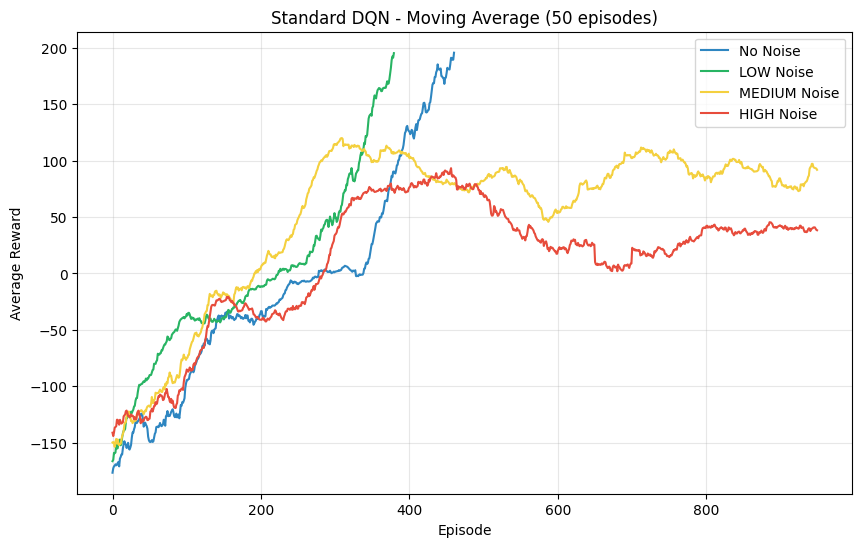

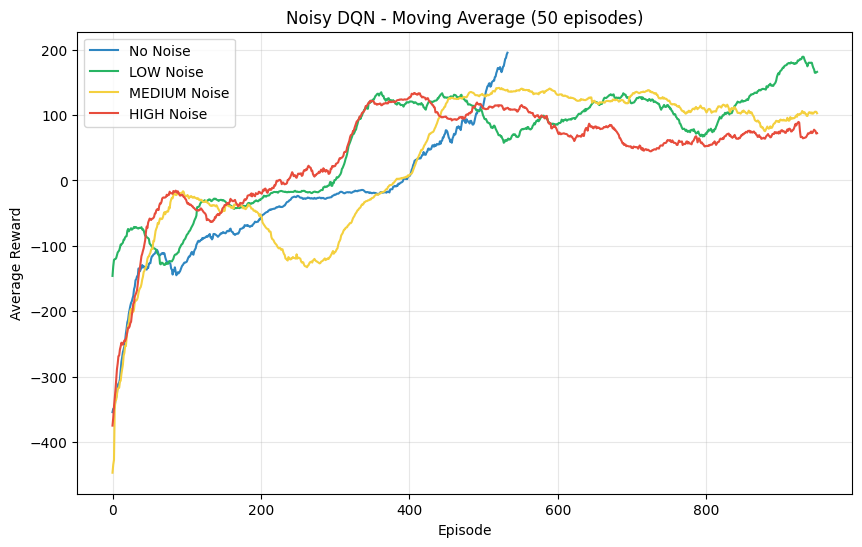

In [28]:
# Create individual plots for each DQN type
window_size = 50

# Colors for different noise levels
colors = {
    "baseline": "#2E86C1",  # Blue
    "LOW": "#28B463",      # Green
    "MEDIUM": "#F4D03F",   # Yellow
    "HIGH": "#E74C3C",     # Red
}

# Plot each DQN type separately
for dqn_type in ["Standard", "Noisy"]:
    plt.figure(figsize=(10, 6))

    # Plot baseline
    plt.plot(
        np.convolve(
            noise_results[f"{dqn_type}_baseline"],
            np.ones(window_size) / window_size,
            mode="valid",
        ),
        label="No Noise",
        color=colors["baseline"],
    )

    # Plot each noise level
    for noise_level in noise_levels:
        moving_avg = np.convolve(
            noise_results[f"{dqn_type}_{noise_level}"],
            np.ones(window_size) / window_size,
            mode="valid",
        )
        plt.plot(
            moving_avg,
            label=f"{noise_level} Noise",
            color=colors[noise_level]
        )

    plt.title(f"{dqn_type} DQN - Moving Average ({window_size} episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()